### Distances 100 shapley points - 6 class training

#### Environment preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

COLAB_ROOT = '/content/drive/MyDrive/PainRecognitionProject/'
print(f"Dane będą wczytywane z: {COLAB_ROOT}")

Mounted at /content/drive
Dane będą wczytywane z: /content/drive/MyDrive/PainRecognitionProject/


In [ ]:
import os

%cd /content

!rm -rf automatic-pain-recognition

print(f"Obecne położenie: {os.getcwd()}")

/content
Obecne położenie: /content


In [ ]:
USERNAME = 'alicka33'
REPO_NAME = 'automatic-pain-recognition'

REPO_URL = f"https://github.com/{USERNAME}/{REPO_NAME}.git"

print("Rozpoczynam klonowanie...")

!git clone {REPO_URL}

%cd $REPO_NAME

Rozpoczynam klonowanie...
Cloning into 'automatic-pain-recognition'...
remote: Enumerating objects: 266, done.
remote: Counting objects: 100% (266/266), done.
remote: Compressing objects: 100% (210/210), done.
remote: Total 266 (delta 119), reused 197 (delta 52), pack-reused 0 (from 0)
Receiving objects: 100% (266/266), 11.27 MiB | 16.05 MiB/s, done.
Resolving deltas: 100% (119/119), done.
/content/automatic-pain-recognition


In [ ]:
!pip install -r requirements.txt

In [ ]:
import sys
import os

sys.path.append(os.getcwd())
print(f"Dodano do ścieżki Pythona: {os.getcwd()}")

Dodano do ścieżki Pythona: /content/automatic-pain-recognition


#### Distances 100 shapley points - 6 class training

In [6]:
import os
import numpy as np
import pandas as pd
import shutil

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

from training_utils.preprocessed_dataset import PreprocessedDataset
from training_utils.train import Trainer
from training_utils.evaluate import Evaluator
from models.Bi_LSTM import SequenceModel

#### Hiperparameters

In [7]:
MAX_SEQUENCE_LENGTH = 37
NUM_FEATURES = 100
NUM_CLASSES = 6
HIDDEN_SIZE = 128
NUM_LAYERS = 2
NUM_EPOCHS = 200
BATCH_SIZE = 16
LEARNING_RATE = 0.00005
DROPOUT_PROB = 0.4
WEIGHT_DECAY = 0.005
SCHEDULER_FACTOR = 0.8

#### Data preparation

In [8]:
COLAB_ROOT = '/content/drive/MyDrive/PainRecognitionProject/'
PROCESSED_DATA_DIR = os.path.join(COLAB_ROOT, 'data/RAVDESS_processed_478_xyz_frontalized/')
MODEL_SAVE_DIR = os.path.join(COLAB_ROOT, 'models/')
LOCAL_PROCESSED_DATA_ROOT = '/content/temp_data/'

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
print("Kopiowanie danych z Google Drive do lokalnej pamięci Colab (RAM)...")
if os.path.exists(LOCAL_PROCESSED_DATA_ROOT):
    shutil.rmtree(LOCAL_PROCESSED_DATA_ROOT)
try:
    shutil.copytree(PROCESSED_DATA_DIR, LOCAL_PROCESSED_DATA_ROOT)
    print("✅ Kopiowanie zakończone pomyślnie. Czas trwania: (sprawdź zegar)")
    CURRENT_DATA_DIR = LOCAL_PROCESSED_DATA_ROOT

except Exception as e:
    print(f"❌ Błąd kopiowania danych (sprawdź, czy dane są zamontowane): {e}")
    print("Używam danych bezpośrednio z Drive (może się zawiesić).")
    CURRENT_DATA_DIR = PROCESSED_DATA_DIR

Kopiowanie danych z Google Drive do lokalnej pamięci Colab (RAM)...
✅ Kopiowanie zakończone pomyślnie. Czas trwania: (sprawdź zegar)


In [10]:
best_100 = np.load('/content/drive/MyDrive/PainRecognitionProject/data/top_100_important_landmarks_emotions.npy')

In [11]:
train_dataset = PreprocessedDataset(
    'train',
    processed_data_dir=CURRENT_DATA_DIR,
    indices=best_100,
    compute_euclidean=True,
    center_point_index=2,
    max_sequence_length=MAX_SEQUENCE_LENGTH,
    selected_labels=[2, 3, 4, 5, 6, 8],
    label_map={2: 0, 3: 1, 4: 2, 5: 3, 6: 4, 8: 5},
)

val_dataset = PreprocessedDataset(
    'val',
    processed_data_dir=CURRENT_DATA_DIR,
    indices=best_100,
    compute_euclidean=True,
    center_point_index=2,
    max_sequence_length=MAX_SEQUENCE_LENGTH,
    selected_labels=[2, 3, 4, 5, 6, 8],
    label_map={2: 0, 3: 1, 4: 2, 5: 3, 6: 4, 8: 5},
)

test_dataset = PreprocessedDataset(
    'test',
    processed_data_dir=CURRENT_DATA_DIR,
    indices=best_100,
    compute_euclidean=True,
    center_point_index=2,
    max_sequence_length=MAX_SEQUENCE_LENGTH,
    selected_labels=[2, 3, 4, 5, 6, 8],
    label_map={2: 0, 3: 1, 4: 2, 5: 3, 6: 4, 8: 5},
)

In [12]:
def preview_single(dataset, idx=0, timesteps_to_show=3, features_to_show=8):
    x, y = dataset[idx]
    print(f"\nSingle sample idx={idx} from split={dataset.dataset_name}")
    print(f"x shape: {tuple(x.shape)}, y: {y}")
    print(np.round(x[:timesteps_to_show, :features_to_show], 4))

preview_single(train_dataset, 0)
preview_single(val_dataset, 0)
preview_single(test_dataset, 0)


Single sample idx=0 from split=train
x shape: (37, 100), y: 0
tensor([[0.2004, 0.2422, 0.1642, 0.1752, 0.1809, 0.1882, 0.1701, 0.2231],
        [0.1973, 0.2360, 0.1626, 0.1764, 0.1766, 0.1833, 0.1658, 0.2216],
        [0.1961, 0.2359, 0.1618, 0.1762, 0.1767, 0.1835, 0.1656, 0.2211]])

Single sample idx=0 from split=val
x shape: (37, 100), y: 0
tensor([[0.2235, 0.2754, 0.1782, 0.1783, 0.1996, 0.2145, 0.1828, 0.2463],
        [0.2210, 0.2703, 0.1766, 0.1775, 0.1968, 0.2114, 0.1818, 0.2443],
        [0.2186, 0.2695, 0.1744, 0.1756, 0.1931, 0.2075, 0.1772, 0.2418]])

Single sample idx=0 from split=test
x shape: (37, 100), y: 0
tensor([[0.2100, 0.2658, 0.1665, 0.1652, 0.1967, 0.2125, 0.1877, 0.2303],
        [0.2117, 0.2679, 0.1670, 0.1654, 0.1955, 0.2127, 0.1855, 0.2315],
        [0.2128, 0.2720, 0.1677, 0.1661, 0.1971, 0.2137, 0.1880, 0.2326]])


In [13]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
for X, y in train_loader:
    print(X.shape, y.shape)  # (B, T_max, num_features)
    break

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
for X, y in val_loader:
    print(X.shape, y.shape)  # (B, T_max, num_features)
    break

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
for X, y in test_loader:
    print(X.shape, y.shape)  # (B, T_max, num_features)
    break

torch.Size([16, 37, 100]) torch.Size([16])
torch.Size([16, 37, 100]) torch.Size([16])
torch.Size([16, 37, 100]) torch.Size([16])


#### Model preparation

In [14]:
model = SequenceModel(NUM_FEATURES, HIDDEN_SIZE, NUM_LAYERS, NUM_CLASSES, DROPOUT_PROB).to(DEVICE)

#### Training

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=SCHEDULER_FACTOR,
    patience=10,
    min_lr=1e-7
)

model_name = 'testing_new_code_emotions_100_distances_6_classes_val_loss.pt'
model_filepath = os.path.join(MODEL_SAVE_DIR, model_name)

In [16]:
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    device=DEVICE,
    model_save_path=model_filepath,
    num_epochs=NUM_EPOCHS,
    monitor='val_loss',  # or 'val_loss'
    minimize_monitor=True,
    save_best_only=True
)

In [17]:
trainer.print_training_config()



🚀 TRAINING CONFIGURATION

--- Model Architecture ---
  Model Type            : SequenceModel
  Input Features        : 100
  Hidden Size           : 128
  Num Layers            : 2
  Bidirectional         : True
  Dropout (LSTM)        : 0.4
  Num Parameters        : 632326

--- Optimizer & Regularization ---
  Optimizer             : AdamW
  Learning Rate (LR)    : 5e-05
  Weight Decay (L2)     : 0.005

--- Training Flow ---
  Batch Size            : 16
  Num Epochs            : 200
  Device                : cuda



In [18]:
final_model_path, best_model_path, history = trainer.fit()
print(f"Final model saved to: {final_model_path}")
if best_model_path:
    print(f"Best model saved to: {best_model_path}")


Starting training for 200 epochs on cuda
Saved best model to /content/drive/MyDrive/PainRecognitionProject/models/best_testing_new_code_emotions_100_distances_6_classes_val_loss.pt (metric=1.7914)
Epoch 1/200 | Time 3.66s | Train loss 1.7929 | Train acc 0.1641 | Val loss 1.7914 | Val acc 0.2298
Saved best model to /content/drive/MyDrive/PainRecognitionProject/models/best_testing_new_code_emotions_100_distances_6_classes_val_loss.pt (metric=1.7908)
Epoch 2/200 | Time 2.58s | Train loss 1.7923 | Train acc 0.1602 | Val loss 1.7908 | Val acc 0.2089
Saved best model to /content/drive/MyDrive/PainRecognitionProject/models/best_testing_new_code_emotions_100_distances_6_classes_val_loss.pt (metric=1.7902)
Epoch 3/200 | Time 2.56s | Train loss 1.7918 | Train acc 0.1862 | Val loss 1.7902 | Val acc 0.1749
Saved best model to /content/drive/MyDrive/PainRecognitionProject/models/best_testing_new_code_emotions_100_distances_6_classes_val_loss.pt (metric=1.7895)
Epoch 4/200 | Time 2.90s | Train loss 

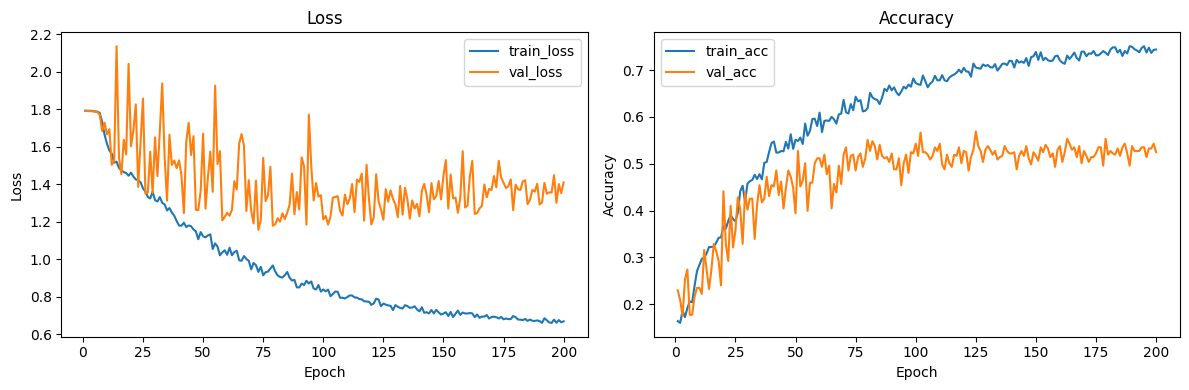

In [19]:
trainer.plot_history()

#### Evaluate

In [20]:
model.load_state_dict(torch.load(best_model_path, map_location=DEVICE), strict=False)

<All keys matched successfully>

In [21]:
evaluator = Evaluator(model, test_loader, device=DEVICE, model_name=model_name, num_classes=NUM_CLASSES)


In [22]:
loss, acc, labels, preds = evaluator.evaluate_epoch()


WYNIKI OCENY DLA MODELU: testing_new_code_emotions_100_distances_6_classes_val_loss.pt
Test Loss: 1.4352
Test Accuracy: 0.5052

--- Szczegółowy Raport Klasyfikacji ---
              precision    recall  f1-score   support

     Klasa 0       0.63      0.42      0.50        64
     Klasa 1       0.95      0.56      0.71        64
     Klasa 2       0.56      0.69      0.62        64
     Klasa 3       0.58      0.69      0.63        64
     Klasa 4       0.33      0.56      0.42        64
     Klasa 5       0.17      0.11      0.13        64

    accuracy                           0.51       384
   macro avg       0.54      0.51      0.50       384
weighted avg       0.54      0.51      0.50       384

Confusion matrix:
 [[27  0 19  0 14  4]
 [ 6 36  0  0  2 20]
 [ 0  0 44 10  8  2]
 [ 0  0  0 44 20  0]
 [10  0  1 10 36  7]
 [ 0  2 15 12 28  7]]
